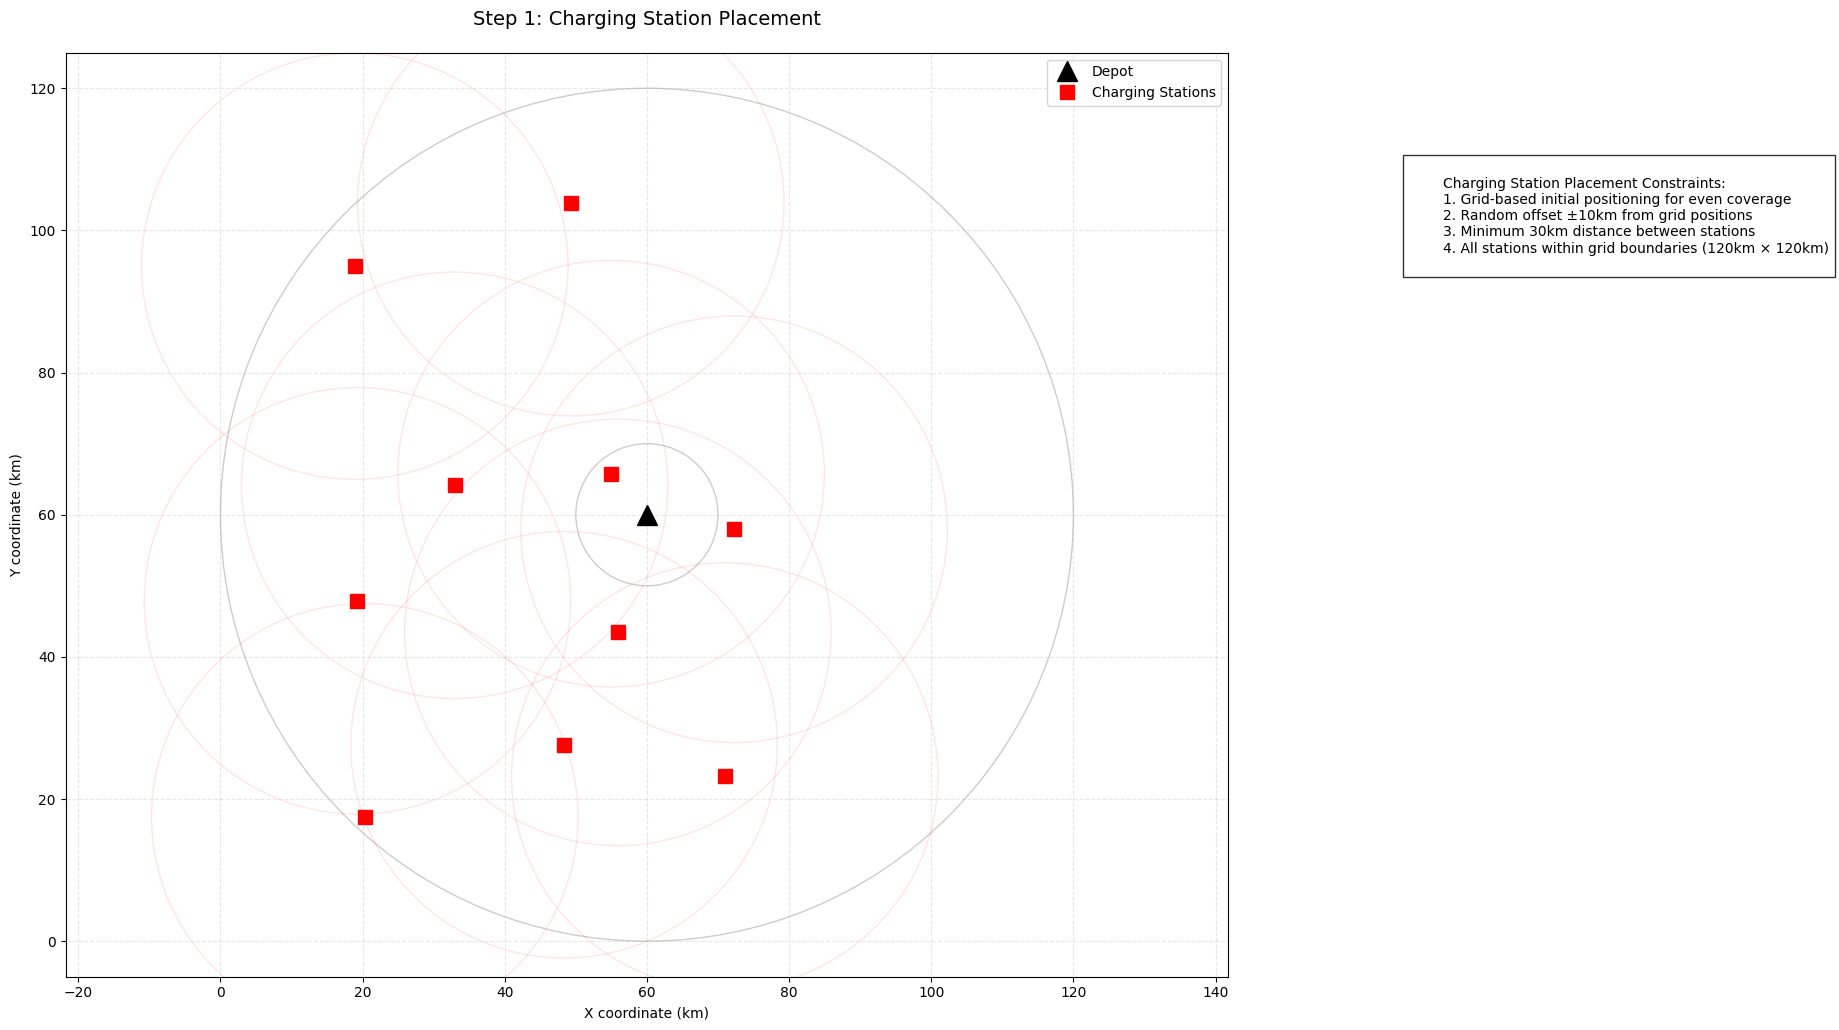

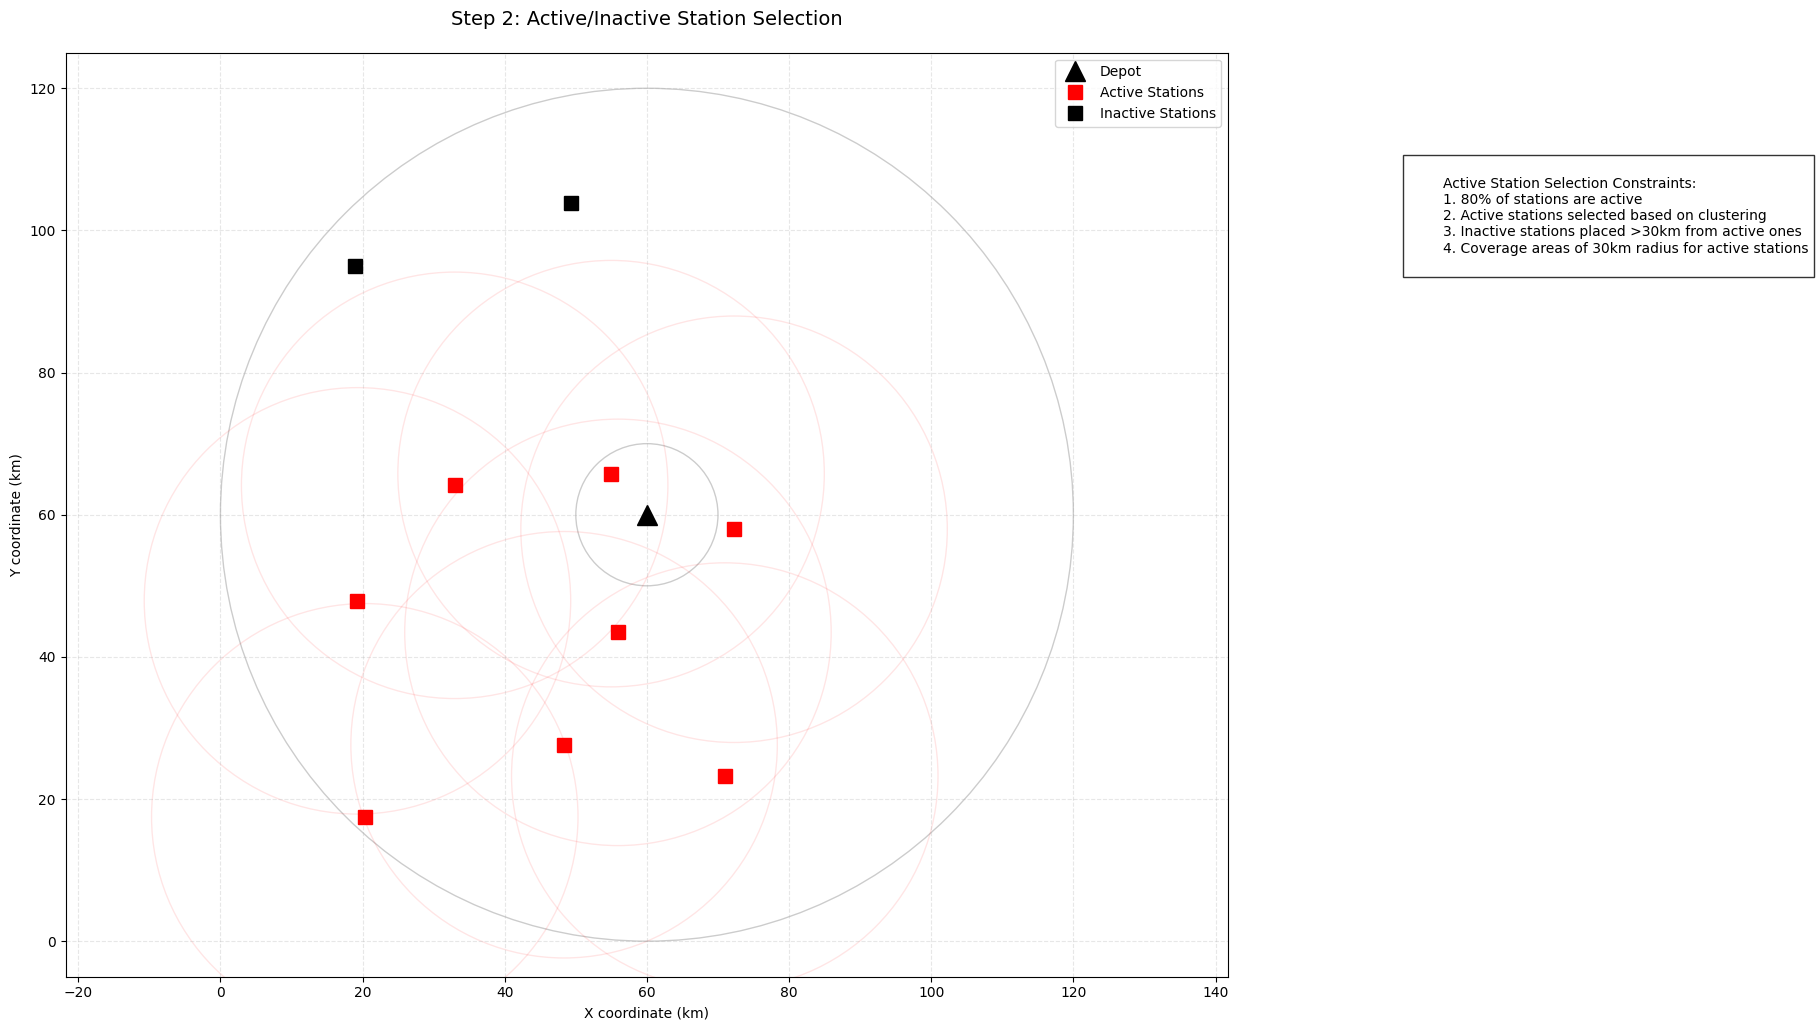

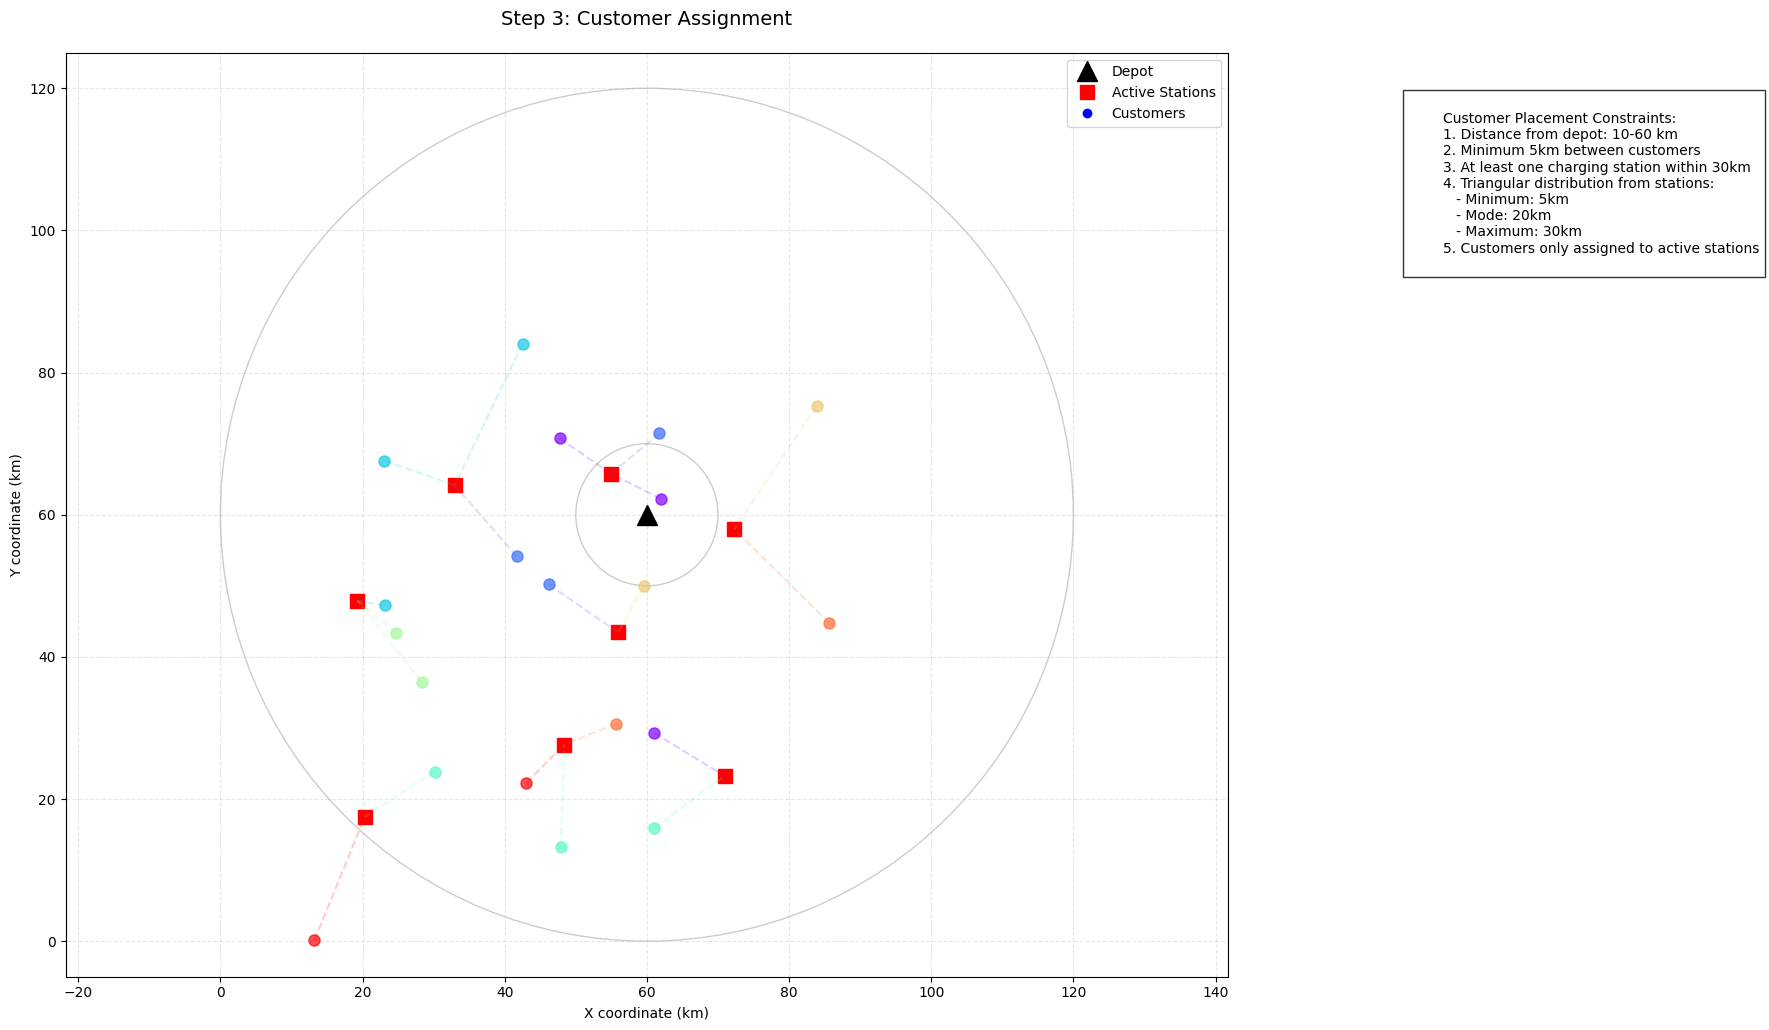

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.colors as mcolors

class StepwiseLocationVisualizer:
    def __init__(self, grid_size=120):
        self.grid_size = grid_size
        self.depot = np.array([grid_size/2, grid_size/2])
        self.fig = None
        self.ax = None
        self.stations = None
        self.active_stations = None
        self.customers = None
        self.step = 0
        
    def setup_plot(self, title):
        """Setup the basic plot with grid and depot"""
        self.fig, self.ax = plt.subplots(figsize=(15, 12))
        
        # Grid
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # Depot
        plt.plot(self.depot[0], self.depot[1], 'k^', markersize=15, label='Depot')
        depot_inner = Circle((self.depot[0], self.depot[1]), 10, color='k', fill=False, alpha=0.2)
        depot_outer = Circle((self.depot[0], self.depot[1]), 60, color='k', fill=False, alpha=0.2)
        self.ax.add_patch(depot_inner)
        self.ax.add_patch(depot_outer)
        
        plt.title(title, pad=20, size=14)
        plt.xlabel('X coordinate (km)')
        plt.ylabel('Y coordinate (km)')
        
        # Set equal aspect ratio and limits
        plt.axis('equal')
        plt.xlim(-5, self.grid_size + 5)
        plt.ylim(-5, self.grid_size + 5)
        
    def step1_charging_stations(self, num_stations=10):
        """Step 1: Initial Charging Station Placement"""
        self.setup_plot("Step 1: Charging Station Placement")
        
        # Generate stations in grid pattern with randomization
        gridDim = int(np.ceil(np.sqrt(num_stations)))
        step = self.grid_size / (gridDim + 1)
        
        stations = []
        for i in range(num_stations):
            base_x = step * (1 + (i // gridDim))
            base_y = step * (1 + (i % gridDim))
            
            # Add controlled randomization
            x = base_x + np.random.uniform(-10, 10)
            y = base_y + np.random.uniform(-10, 10)
            stations.append(np.array([x, y]))
        
        self.stations = np.array(stations)
        
        # Plot stations
        plt.plot(self.stations[:, 0], self.stations[:, 1], 'rs', 
                markersize=10, label='Charging Stations')
        
        # Show coverage areas
        for station in self.stations:
            coverage = Circle((station[0], station[1]), 30, 
                            color='r', fill=False, alpha=0.1)
            self.ax.add_patch(coverage)
        
        # Add constraints description
        constraint_text = """
        Charging Station Placement Constraints:
        1. Grid-based initial positioning for even coverage
        2. Random offset ±10km from grid positions
        3. Minimum 30km distance between stations
        4. All stations within grid boundaries (120km × 120km)
        """
        plt.figtext(1.02, 0.7, constraint_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.legend(loc='upper right')
        return self.fig
        
    def step2_active_stations(self):
        """Step 2: Active/Inactive Station Selection"""
        self.setup_plot("Step 2: Active/Inactive Station Selection")
        
        # Select 80% stations as active
        num_active = int(0.8 * len(self.stations))
        
        # Calculate station distances from each other
        distances = []
        for i, station in enumerate(self.stations):
            total_dist = sum(np.linalg.norm(station - other) 
                           for j, other in enumerate(self.stations) if i != j)
            distances.append((i, total_dist))
        
        # Sort by total distance and select most clustered as active
        distances.sort(key=lambda x: x[1])
        active_indices = [idx for idx, _ in distances[:num_active]]
        
        self.active_stations = self.stations[active_indices]
        inactive_stations = self.stations[[i for i in range(len(self.stations)) 
                                        if i not in active_indices]]
        
        # Plot active stations
        plt.plot(self.active_stations[:, 0], self.active_stations[:, 1], 'rs', 
                markersize=10, label='Active Stations')
        for station in self.active_stations:
            coverage = Circle((station[0], station[1]), 30, 
                            color='r', fill=False, alpha=0.1)
            self.ax.add_patch(coverage)
            
        # Plot inactive stations
        plt.plot(inactive_stations[:, 0], inactive_stations[:, 1], 'ks', 
                markersize=10, label='Inactive Stations')
        
        # Add constraints description
        constraint_text = """
        Active Station Selection Constraints:
        1. 80% of stations are active
        2. Active stations selected based on clustering
        3. Inactive stations placed >30km from active ones
        4. Coverage areas of 30km radius for active stations
        """
        plt.figtext(1.02, 0.7, constraint_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.legend(loc='upper right')
        return self.fig
        
    def step3_customer_placement(self, num_customers=20):
        """Step 3: Customer Assignment"""
        self.setup_plot("Step 3: Customer Assignment")
        
        # Generate customers around active stations
        customers = []
        colors = []
        station_colors = plt.cm.rainbow(np.linspace(0, 1, len(self.active_stations)))
        
        customers_per_station = num_customers // len(self.active_stations)
        extra_customers = num_customers % len(self.active_stations)
        
        for i, station in enumerate(self.active_stations):
            n_customers = customers_per_station + (1 if i < extra_customers else 0)
            
            for _ in range(n_customers):
                # Generate customer with triangular distribution
                radius = np.random.triangular(5, 20, 30)
                angle = np.random.uniform(0, 2*np.pi)
                
                x = station[0] + radius * np.cos(angle)
                y = station[1] + radius * np.sin(angle)
                
                customers.append(np.array([x, y]))
                colors.append(station_colors[i])
        
        self.customers = np.array(customers)
        
        # Plot stations
        plt.plot(self.active_stations[:, 0], self.active_stations[:, 1], 'rs', 
                markersize=10, label='Active Stations')
        
        # Plot customers with connections
        for customer, color in zip(self.customers, colors):
            plt.plot(customer[0], customer[1], 'o', color=color, 
                    markersize=8, alpha=0.7)
            
            # Find nearest station
            distances = [np.linalg.norm(customer - station) 
                        for station in self.active_stations]
            nearest_station = self.active_stations[np.argmin(distances)]
            
            # Draw connection
            plt.plot([customer[0], nearest_station[0]], 
                    [customer[1], nearest_station[1]], 
                    '--', color=color, alpha=0.2)
        
        # Add constraints description
        constraint_text = """
        Customer Placement Constraints:
        1. Distance from depot: 10-60 km
        2. Minimum 5km between customers
        3. At least one charging station within 30km
        4. Triangular distribution from stations:
           - Minimum: 5km
           - Mode: 20km
           - Maximum: 30km
        5. Customers only assigned to active stations
        """
        plt.figtext(1.02, 0.7, constraint_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        plt.plot([], [], 'o', color='blue', label='Customers')
        plt.legend(loc='upper right')
        return self.fig

def visualize_all_steps(num_stations=10, num_customers=20):
    """Generate all three visualization steps"""
    visualizer = StepwiseLocationVisualizer()
    
    # Generate and save each step
    steps = [
        visualizer.step1_charging_stations(num_stations),
        visualizer.step2_active_stations(),
        visualizer.step3_customer_placement(num_customers)
    ]
    
    return steps

# Example usage
if __name__ == "__main__":
    steps = visualize_all_steps(10, 20)
    plt.show()